## 0 - Import libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
# Pre-define chart function
def chart(df, x, y, title, color=alt.value('steelblue'), width=480, height=320):
    return alt.Chart(df).encode(
        x=x,
        y=y,
        color=color,
    ).properties(
    title=title,
    width=width,
    height=height,
).configure(
    axis=alt.AxisConfig(
        domain=False, # remove axis line
        ticks=False, # remove ticks
        labelAngle=0, # rotate labels
        labelColor='gray', # color of labels
        labelFontSize=10,
    ),
    font='Helvetica Neue',
    view=alt.ViewConfig(stroke=None), # remove border
)


figure_path = os.path.join('..', 'reports', 'figures')

## 1 - Load the training data

In [3]:
input_path = os.path.join('..', 'data', 'cleaned')

train_df = pd.read_parquet(os.path.join(input_path, 'train.parquet'))
train_df.head()

,file,VMONTH,VYEAR,VDAYR,AGE,AGER,SEX,ETHNIC,RACE,USETOBAC,...,REFOTHMD,RETAPPT,OTHDISP,ERADMHOS,RFV1_TEXT,RFV2_TEXT,RFV3_TEXT,DIAG1_TEXT,DIAG2_TEXT,DIAG3_TEXT
0,opd2006,12,2006,6,55,4,2,2,1,1,...,0,0,0,0,"Injury, other and unspecified, of sho...",None,None,"Shoulder and upper arm injury, other ...",None,None
1,opd2006,11,2006,5,66,5,2,2,1,1,...,0,0,0,0,Cough,None,None,"Bronchitis, not specified as acute or...",None,None
2,opd2006,11,2006,4,71,5,1,2,1,1,...,1,0,0,0,General ill feeling,Abnormal eye movements,None,Dizziness and giddiness,"Diabetes mellitus w/o complication, t...",Unspecified essential hypertension
3,opd2006,11,2006,3,1,1,1,2,1,1,...,0,0,0,0,Other and unspecified symptoms refera...,None,None,Unspecified otitis media,Acute upper respiratory infections of...,Chronic rhinitis
4,opd2006,11,2006,2,21,2,1,2,1,2,...,0,0,0,0,Throat soreness,Sinus problems,None,Unspecified sinusitis (chronic),None,None


## 2 - Load the vairiables dictionary and define features for clustering

In [4]:
# Load the variables dictionary
with open(os.path.join(input_path, 'variables.json'), 'r') as f:
    variables = json.load(f)

print(f'Variable Categories:\n')
for category, list in variables.items():
    print(f'{category}')
    print(f'{list}')

Variable Categories:

dateOfVisit
['VMONTH', 'VYEAR', 'VDAYR']
demographics
['AGE', 'AGER', 'SEX', 'ETHNIC', 'RACE', 'USETOBAC']
payment
['PAYPRIV', 'PAYMCARE', 'PAYMCAID', 'PAYWKCMP', 'PAYSELF', 'PAYNOCHG', 'PAYOTH', 'PAYDK', 'PAYTYPER']
visitReason
['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
patientClinicHistory
['SENBEFOR', 'PASTVIS']
vitalSigns
['HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
imputedFields
['BDATEFL', 'SEXFL', 'SENBEFL', 'PASTFL']
physicianDiagnoses
['DIAG1', 'DIAG2', 'DIAG3']
differentialDiagnoses
['PRDIAG1', 'PRDIAG2', 'PRDIAG3']
presentSymptomsStatus
['ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
services
['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'PAPUNSP', 'HPVDNA', 'EKG', 'URINE', 'HTTAKE', 'WTTAKE

### 2.1 Defining features

##### !!! The statistical test result of the features should be referred first

In [5]:
train_df[variables['visitReason']].value_counts()

INJDET  MAJOR  RFV1   RFV2   RFV3 
5       2      48000  44100  41150    40
1       2      23200  48000  44100    25
5       1      10100  14400  14000    21
               14400  14000  14551    21
1       3      46050  47350  11500    20
                                      ..
5       1      14400  15950  15300     1
                             14750     1
                             10200     1
                      15702  41150     1
        5      89980  45650  42050     1
Name: count, Length: 7796, dtype: int64

In [6]:
# Defining the independent variables as features for classification
features = \
    ['AGE', 'AGER', 'SEX', 'USETOBAC'] + variables['visitReason'] + ['PASTVIS'] + variables['vitalSigns'] \
    + variables['presentSymptomsStatus'] + variables['textFeature']

print(f'Features: {features}')
print(f'Number of Features: {len(features)}')

Features: ['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT', 'DIAG3_TEXT']
Number of Features: 37


In [12]:
X_train = train_df.loc[:, features].copy()

## 3 - Preprocess and engineer the features

 ### 3.1 - Bin the Reason for Visit variables into Modules
 RFV1, RFV2, RFV3

In [13]:
# Load the REASON FOR VISIT classification summary of codes
rfv_summary = pd.read_excel(os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx'))

# Split the 'CODE NUMBER' column into 'START' and 'END' columns
rfv_summary[['START', 'END']] = rfv_summary['CODE NUMBER'].str.split('-', expand=True).astype(int)

# Remove the leading and trailing whitespaces from `MODULE_1` and `MODULE_2` columns
rfv_summary['MODULE_1'] = rfv_summary['MODULE_1'].str.strip()
rfv_summary['MODULE_2'] = rfv_summary['MODULE_2'].str.strip()

rfv_summary.head(5)

,MODULE_1,MODULE_2,CODE NUMBER,START,END
0,SYMPTOM MODULE,General Symptoms,1001-1099,1001,1099
1,SYMPTOM MODULE,Symptoms Referable to Psychological and Mental...,1100-1199,1100,1199
2,SYMPTOM MODULE,Symptoms Referable to the Nervous System (Excl...,1200-1259,1200,1259
3,SYMPTOM MODULE,Symptoms Referable to the Cardiovascular and L...,1260-1299,1260,1299
4,SYMPTOM MODULE,Symptoms Referable to the Eyes and Ears,1300-1399,1300,1399


In [14]:
# Find the `START` and `END` range, 
# and map the corresponding `MODULE_1` and `MODULE_2` to X_train as new columns `MODULE_1` and `MODULE_2`,
# according to the value of `RFV1`, `RFV2`, and `RFV3` columns
def get_module(code):
    module = rfv_summary.loc[(rfv_summary['START'] <= code) & (rfv_summary['END'] >= code), ['MODULE_1', 'MODULE_2']]
    if len(module) == 0:
        return pd.Series([pd.NA, pd.NA], index=['MODULE_1', 'MODULE_2'])
    else:
        return module.iloc[0]



X_train[['RFV1_MOD1', 'RFV1_MOD2']] = X_train['RFV1'].apply(lambda x: get_module(int(str(x)[:4])) if pd.notna(x) else pd.Series([pd.NA, pd.NA], index=['MODULE_1', 'MODULE_2']))
print(f'RFV1 unique values: \n{X_train["RFV1_MOD2"].value_counts()}')

X_train[['RFV2_MOD1', 'RFV2_MOD2']] = X_train['RFV2'].apply(lambda x: get_module(int(str(x)[:4])) if pd.notna(x) else pd.Series([pd.NA, pd.NA], index=['MODULE_1', 'MODULE_2']))
print(f'RFV2 unique values: \n{X_train["RFV2_MOD2"].value_counts()}')

X_train[['RFV3_MOD1', 'RFV3_MOD2']] = X_train['RFV3'].apply(lambda x: get_module(int(str(x)[:4])) if pd.notna(x) else pd.Series([pd.NA, pd.NA], index=['MODULE_1', 'MODULE_2']))
print(f'RFV3 unique values: \n{X_train["RFV3_MOD2"].value_counts()}')

RFV1 unique values: 
RFV1_MOD2
Progress Visit, NEC                                                  9641
Symptoms Referable to the Musculoskeletal System                     8232
Special Examinations                                                 7416
General Examinations                                                 6895
Symptoms Referable to the Respiratory System                         5908
General Symptoms                                                     4536
Injury by Type and/or Location                                       4312
Symptoms Referable to Psychological and Mental Disorders             4048
Symptoms Referable to the Genitourinary System                       3847
Diagnostic Tests                                                     3801
Symptoms Referable to the Digestive System                           3301
Preoperative and Postoperative Care                                  2971
Symptoms Referable to the Skin, Nails, and Hair                      2845
Symptom

### 3.2 - Binning of quantitative variables to categorical features
Bin the following quantitative variables:

AGE, BMI, TEMPF, BPSYS, BPDIAS

#### 3.2.1 - Bin the AGE variable
Do we bin as recoded age groups (`AGER`) or as each 20 years?

In [15]:
# Check the distribution of `AGER`
# 1 = Under 15 years 
# 2 = 15-24 years 
# 3 = 25-44 years 
# 4 = 45-64 years 
# 5 = 65-74 years 
# 6 = 75 years and over|
 
chart(
    df=train_df,
    x='AGER:O',
    y='count()',
    title='Distribution of AGER',
).mark_bar()

alt.Chart(...)

In [16]:
# Bin the AGE variable as age groups
# 0-2 = Infant
# 2-4 = Toddler
# 4-12 = Child
# 12-20 = Teenager
# 20-40 = Adult
# 40-60 = Middle Aged
# >= 60 = Senior

age_groups = ['Infant', 'Toddler', 'Child', 'Teenager', 'Child or Teenager', 'Adult', 'Middle Aged', 'Senior']

def bin_age(age):
    if pd.isna(age): return pd.NA
    #if age < 2: return 'Infant'
    #elif age < 4: return 'Toddler'
    #elif age < 12: return 'Child'
    #elif age < 20: return 'Teenager'
    elif age < 20: return 'Child or Teenager'
    elif age < 40: return 'Adult'
    elif age < 60: return 'Middle Aged'
    else: return 'Senior'
    

X_train['AGE_GROUP'] = X_train['AGE'].apply(bin_age)

# Check the distribution of age groups
chart(
    df=X_train,
    x=alt.X('AGE_GROUP:O', sort=age_groups),
    y='count()',
    title='Distribution of AGE GROUPS',
).mark_bar()

alt.Chart(...)

#### 3.2.2 - Bin the vitalSigns variables
BMI, TEMPF, BPSYS, BPDIAS

In [17]:
# Bin the BMI as weight status
# <18.5 = Underweight
# 18.5-25 = Normal weight
# 25-30 = Overweight
# >=30 = Obesity

bmi_groups = ['Underweight', 'Normal weight', 'Overweight', 'Obesity']

def bin_bmi(bmi):
    if pd.isna(bmi): return pd.NA
    elif bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal weight'
    elif bmi < 30: return 'Overweight'
    else: return 'Obesity'

X_train['BMI_GROUP'] = X_train['BMI'].apply(bin_bmi)

# Check the distribution of BMI groups
chart(
    df=X_train,
    x=alt.X('BMI_GROUP:O', sort=bmi_groups),
    y='count()',
    title='Distribution of BMI GROUPS',
).mark_bar()

alt.Chart(...)

In [18]:
# Bin the TEMPF as fever status
# <95 = Hypothermia
# 95-99 = Normal temperature
# 99-100 = Low grade fever
# 100-103 = Fever
# >=103 = Hyperpyrexia

tempf_groups = ['Hypothermia', 'Normal temperature', 'Low grade fever', 'Fever', 'Hyperpyrexia']

def bin_tempf(tempf):
    if pd.isna(tempf): return pd.NA
    elif tempf < 95: return 'Hypothermia'
    elif tempf < 99: return 'Normal temperature'
    #elif tempf < 100: return 'Low grade fever'
    elif tempf < 103: return 'Fever'
    else: return 'Hyperpyrexia'

X_train['TEMPF_GROUP'] = X_train['TEMPF'].apply(bin_tempf)

# Check the distribution of TEMPF groups
chart(
    df=X_train,
    x=alt.X('TEMPF_GROUP:O', sort=tempf_groups),
    y='count()',
    title='Distribution of TEMPF GROUPS',
).mark_bar()

alt.Chart(...)

In [19]:
# Bin the BPSYS as systolic blood pressure status
# <90 = Hypotension
# 90-120 = Normal blood pressure
# 120-140 = Prehypertension
# >=140 = Hypertension

bpsys_groups = ['Hypotension', 'Normal blood pressure', 'Prehypertension', 'Hypertension']

def bin_bpsys(bpsys):
    if pd.isna(bpsys): return pd.NA
    elif bpsys < 90: return 'Hypotension'
    elif bpsys < 120: return 'Normal blood pressure'
    elif bpsys < 140: return 'Prehypertension'
    else: return 'Hypertension'

X_train['BPSYS_GROUP'] = X_train['BPSYS'].apply(bin_bpsys)

# Check the distribution of BPSYS groups
chart(
    df=X_train,
    x=alt.X('BPSYS_GROUP:O', sort=bpsys_groups),
    y='count()',
    title='Distribution of BPSYS GROUPS',
).mark_bar()

alt.Chart(...)

In [20]:
# Bin the BPDIAS as diastolic blood pressure status
# <60 = Low diastolic blood pressure
# 60-90 = Normal diastolic blood pressure
# 90-110 = High diastolic blood pressure
# >=110 = Hypertension

bpdias_groups = [
    'Low diastolic blood pressure', 'Normal diastolic blood pressure', 'High diastolic blood pressure', 'Hypertension'
]

def bin_bpdias(bpdias):
    if pd.isna(bpdias): return pd.NA
    elif bpdias < 60: return 'Low diastolic blood pressure'
    elif bpdias < 90: return 'Normal diastolic blood pressure'
    elif bpdias < 110: return 'High diastolic blood pressure'
    else: return 'Hypertension'

X_train['BPDIAS_GROUP'] = X_train['BPDIAS'].apply(bin_bpdias)

# Check the distribution of BPDIAS groups
chart(
    df=X_train,
    x=alt.X('BPDIAS_GROUP:O', sort=bpdias_groups),
    y='count()',
    title='Distribution of BPDIAS GROUPS',
).mark_bar().configure_axisX(labelAngle=45)

alt.Chart(...)

### 3.3 - Create interaction features
AGE, HTIN, WTLB, BMI, BPSYS, BPDIAS, CEBVD, CHF, DIABETES, HYPLIPID, HTN, OBESITY

### 3.4 - Redefine the features for training

In [27]:
binary_features = [feature for feature in features if X_train[feature].nunique() == 2]
print(f'Binary Features: {binary_features}')

ordinal_features = ['CASTAGE']
print(f'Ordinal Features: {ordinal_features}')
print()

# With Binned Groups
quantitative_features_w_bin = ['PASTVIS', 'HTIN', 'WTLB']
print(f'Quantitative Features with Binned Groups: {quantitative_features_w_bin}')

nominal_features_w_bin = ['INJDET', 'MAJOR'] + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2'] + ['AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
print(f'Nominal Features with Binned Groups: {nominal_features_w_bin}')

print(f'Number of Features with Binned Groups: {len(quantitative_features_w_bin + binary_features + ordinal_features + nominal_features_w_bin)}')
print()

# Without Binned Groups
quantitative_features_wo_bin = ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
print(f'Quantitative Features without Binned Groups: {quantitative_features_wo_bin}')
nominal_features_wo_bin = ['INJDET', 'MAJOR'] + ['RFV1', 'RFV2', 'RFV3']
print(f'Nominal Features without Binned Groups: {nominal_features_wo_bin}')

print(f'Number of Features without Binned Groups: {len(quantitative_features_wo_bin + binary_features + ordinal_features + nominal_features_wo_bin)}')


Binary Features: ['SEX', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
Ordinal Features: ['CASTAGE']

Quantitative Features with Binned Groups: ['PASTVIS', 'HTIN', 'WTLB']
Nominal Features with Binned Groups: ['INJDET', 'MAJOR', 'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
Number of Features with Binned Groups: 32

Quantitative Features without Binned Groups: ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
Nominal Features without Binned Groups: ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
Number of Features without Binned Groups: 29


### 3.5 - Handeling missing values in categorical features

In [22]:
# Check the missing values in X_train
print(f'Missing Values in X_train: \n{X_train.isna().sum().where(lambda x: x > 0).dropna()}')
print()

# Fill the missing values in the categorical features
# with -9 for 'CASTAGE',
# with -999 for 'USETOBAC', 'INJDET', 'MAJOR',
# with -9 for 'RFV1', 'RFV2', 'RFV3'
# with 'NA' for 'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2',
# with 'NA' for 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP'
X_train.fillna({'CASTAGE': -9}, inplace=True)
X_train.fillna({'USETOBAC': -999, 'INJDET': -999, 'MAJOR': -999}, inplace=True)
X_train.fillna({'RFV1': -9, 'RFV2': -9, 'RFV3': -9}, inplace=True)
X_train.fillna(
    {
        'RFV1_MOD1': 'NA', 'RFV2_MOD1': 'NA', 'RFV3_MOD1': 'NA',
        'RFV1_MOD2': 'NA', 'RFV2_MOD2': 'NA', 'RFV3_MOD2': 'NA',
        'BMI_GROUP': 'NA', 'TEMPF_GROUP': 'NA', 'BPSYS_GROUP': 'NA', 'BPDIAS_GROUP': 'NA'
    },
    inplace=True
)


# Check the missing values in X_train after filling
print(f'Missing Values in X_train after Filling: \n{X_train.isna().sum().where(lambda x: x > 0).dropna()}')

Missing Values in X_train: 
USETOBAC         40100.0
INJDET           32459.0
MAJOR             2103.0
RFV1              1268.0
RFV2             67179.0
RFV3             90754.0
PASTVIS          19878.0
HTIN             56172.0
WTLB             34554.0
BMI              65377.0
TEMPF            57028.0
BPSYS            40808.0
BPDIAS           40923.0
CASTAGE         100260.0
RFV1_TEXT         1268.0
RFV2_TEXT        67179.0
RFV3_TEXT        90754.0
DIAG1_TEXT         786.0
DIAG2_TEXT       52698.0
DIAG3_TEXT       79620.0
RFV1_MOD1         1268.0
RFV1_MOD2         1268.0
RFV2_MOD1        67179.0
RFV2_MOD2        67179.0
RFV3_MOD1        90754.0
RFV3_MOD2        90754.0
BMI_GROUP        65377.0
TEMPF_GROUP      57028.0
BPSYS_GROUP      40808.0
BPDIAS_GROUP     40923.0
dtype: float64

Missing Values in X_train after Filling: 
PASTVIS       19878.0
HTIN          56172.0
WTLB          34554.0
BMI           65377.0
TEMPF         57028.0
BPSYS         40808.0
BPDIAS        40923.0
RFV1_TEXT 

## 4 - Prepare dependent variables

In [23]:
# Check the missing values in 'DIAG1', 'DIAG2', and 'DIAG3'
print(f'Missing Values in DIAG1: {train_df["DIAG1"].isna().sum()}')
print(f'Missing Values in DIAG2: {train_df["DIAG2"].isna().sum()}')
print(f'Missing Values in DIAG3: {train_df["DIAG3"].isna().sum()}')
print()

# Check the numbers of ruled out or questionable diagnoses
# (when 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' equals to 1)
print(f'Number of Ruled Out Diagnoses in DIAG1: {train_df["PRDIAG1"].sum()}')
print(f'Number of Ruled Out Diagnoses in DIAG2: {train_df["PRDIAG2"].sum()}')
print(f'Number of Ruled Out Diagnoses in DIAG3: {train_df["PRDIAG3"].sum()}')
print()

# Check the number of samples with missing 'DIAG1' and 'PRDIAG1' equals to 1
print(f'Number of Samples with Missing DIAG1 and PRDIAG1 equals to 1: {train_df[(train_df["DIAG1"].isna()) & (train_df["PRDIAG1"] == 1)].shape[0]}')
print()

# Check the number of available dependent samples
# (when 'DIAG1' is not missing and 'PRDIAG1' is not 1)
print(f'Number of Available Dependent Samples: {train_df[(~train_df["DIAG1"].isna()) & (train_df["PRDIAG1"] != 1)].shape[0]}')

Missing Values in DIAG1: 1444
Missing Values in DIAG2: 53134
Missing Values in DIAG3: 79860

Number of Ruled Out Diagnoses in DIAG1: 940
Number of Ruled Out Diagnoses in DIAG2: 1054
Number of Ruled Out Diagnoses in DIAG3: 493

Number of Samples with Missing DIAG1 and PRDIAG1 equals to 1: 5

Number of Available Dependent Samples: 101107


### 4.1 - Load and the list of three-digit categories of ICD-9-CM

In [24]:
# Load the list of three-digit categories of ICD-9-CM
icd9cm_3dcat = pd.read_excel(os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx'), dtype=str)

icd9cm_3dcat.head()

,3D_CODE,DISEASE,CATEGORY_1,CATEGORY_2
0,001,Cholera,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
1,002,Typhoid and paratyphoid fevers,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
2,003,Other salmonella infections,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
3,004,Shigellosis,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
4,005,Other food poisoning (bacterial),INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases


### 4.2 - Employing the hierachical classifications of ICD-9-CM codes to prepare the target labels

In [25]:
# Map the three-digit categories of ICD-9-CM to 'DIAG1', 'DIAG2', and 'DIAG3',
# if 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' are not 1 respectively

def get_icd9cm_3dcat(diag, prdiag, category='CATEGORY_1'):
    try:
        if pd.notna(diag) and (pd.isna(prdiag) | prdiag != 1):
            if diag == 'V997-':
                return 'No diagnosis/disease or healthy'
            else:
                return icd9cm_3dcat[icd9cm_3dcat['3D_CODE'] == diag[:3]][category].values[0]
        else:
            return pd.NA
    except:
        print(f'Error: {diag}')
        print(f'Error: {prdiag}')

    
get_icd9cm_3dcat(train_df.iloc[0].DIAG1, train_df.iloc[0].PRDIAG1, category='CATEGORY_2')

'Certain traumatic complications and unspecified injuries'

In [26]:
# Map the three-digit categories of ICD-9-CM to 'DIAG1', 'DIAG2', and 'DIAG3',
# if 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' are not 1 respectively

y_train = train_df.apply(lambda x: get_icd9cm_3dcat(x.DIAG1, x.PRDIAG1, category='CATEGORY_1'), axis=1)
y_train_cat2 = train_df.apply(lambda x: get_icd9cm_3dcat(x.DIAG1, x.PRDIAG1, category='CATEGORY_2'), axis=1)

print(f'Dependent DataFrame with CATEGORY_1 Shape: {y_train.shape}')
print(f'Dependent DataFrame with CATEGORY_2 Shape: {y_train_cat2.shape}')

Dependent DataFrame with CATEGORY_1 Shape: (103486,)
Dependent DataFrame with CATEGORY_2 Shape: (103486,)


### 4.3 - Drop the rows from both X_train, y_train with NA in y_train

In [27]:
print(f'Number of available dependent samples: {y_train.notna().sum()}')
print()

non_missing_mask = y_train.notna()

X_train = X_train.loc[non_missing_mask]

y_train = y_train.loc[non_missing_mask]
y_train_cat2 = y_train_cat2[non_missing_mask]

print(f'X_train Shape: {X_train.shape}')
print(f'y_train with CATEGORY_1 Shape: {y_train.shape}')
print(f'y_train with CATEGORY_2 Shape: {y_train_cat2.shape}')

Number of available dependent samples: 101107

X_train Shape: (101107, 48)
y_train with CATEGORY_1 Shape: (101107,)
y_train with CATEGORY_2 Shape: (101107,)


### 4.4 - Add in text feature
From 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT'

From combined textual feature

#### 4.4.1 - Combine and preprocess textual features

In [103]:
#Convert and combine textual features into 'TEXT'
def combine_textual(row, features):
    row['TEXT'] = ''

    for feature in features:
        if feature == 'AGE':
            if pd.notna(row[feature]):
                # Combine 'AGE' as direct text description followed by 'AGE_GROUP'
                row['TEXT'] = ' '.join([
                    row['TEXT'], f'{int(row[feature])}_year_old',
                    '_'.join(row['AGE_GROUP'].split())
                ])
            continue

        if feature == 'SEX':
            if pd.notna(row[feature]):
                if row[feature] == 1:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Female'])
                elif row[feature] == 0:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Male'])
            continue

        # Comine `USETOBAC` if the patient is a current tobacco user
        if feature == 'USETOBAC':
            if row[feature] == 2:
                row['TEXT'] = ' '.join([row['TEXT'], 'Tobacco_User'])
            continue

        # Combine `visitReason` and rule out the non-relevant reasons
        if feature == 'INJDET':
            if pd.notna(row[feature]):
                if row[feature] == 1:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Unintentional injury/poisoning'])
                elif row[feature] == 2:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Intentional injury/poisoning'])
                elif row[feature] == 3:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Injury/poisoning - unknown_intent'])
                elif row[feature] == 4:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Adverse_effect of medical/surgical care or adverse_effect of medicinal drug'])
            continue

        if feature == 'MAJOR':
            if pd.notna(row[feature]):
                if row[feature] == 1:
                    row['TEXT'] = ' '.join([row['TEXT'], 'New problem'])
                elif row[feature] == 2:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Chronic problem, routine'])
                elif row[feature] == 3:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Chronic problem, flare_up'])
                elif row[feature] == 4:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Pre-/Post-surgery'])
                elif row[feature] == 5:
                    row['TEXT'] = ' '.join([row['TEXT'], 'Preventive care (e.g. routine prenatal, well-baby, screening, insurance, general exams)'])
            continue

        if feature in ['RFV1', 'RFV2', 'RFV3']:
            if pd.notna(row[feature]) & (row[feature] != -9):
                # Combine 'RFVx_TEXT', followed by 'RFVx_MOD2', 'RFVx_MOD1'
                row['TEXT'] = ' '.join([row['TEXT'], row[f'{feature}_TEXT'], row[f'{feature}_MOD2'], row[f'{feature}_MOD1']])
            continue

        if feature in ['BMI', 'TEMPF', 'BPSYS', 'BPDIAS']:
            if pd.notna(row[feature]):
                # Combine 'feature_GROUP'
                row['TEXT'] = ' '.join([
                    row['TEXT'],
                    '_'.join(row[f'{feature}_GROUP'].split())
                ])
            continue

        # Convert and combine `presentSymptomsStatus` as direct text description
        if feature == 'ARTHRTIS':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Arthritis'])
            continue

        if feature == 'ASTHMA':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Asthma'])
            continue

        if feature == 'CANCER':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], '_'.join((row['CASTAGE'] + ' Cancer').split())])
            continue

        if feature == 'CEBVD':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Cerebrovascular_disease'])
            continue

        if feature == 'CHF':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Congestive_heart_failure'])
            continue

        if feature == 'CRF':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Chronic_renal_failure'])
            continue

        if feature == 'COPD':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Chronic_obstructive_pulmonary_disease'])
            continue

        if feature == 'DEPRN':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Depression'])
            continue

        if feature == 'DIABETES':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Diabetes'])
            continue

        if feature == 'HYPLIPID':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Hyperlipidemia'])
            continue

        if feature == 'HTN':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Hypertension'])
            continue

        if feature == 'IHD':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Ischemic_heart_disease'])
            continue

        if feature == 'OBESITY':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Obesity'])
            continue

        if feature == 'OSTPRSIS':
            if row[feature] == 1:
                row['TEXT'] = ' '.join([row['TEXT'], 'Osteoporosis'])
            continue

        # Combine `physicianDiagnoses` and rule out 'PROBABLE, QUESTIONABLE, OR RULE OUT' diagnoses
        if feature in ['DIAG1', 'DIAG2', 'DIAG3']:
            if pd.notna(row[feature]) and (pd.isna(row[f'PR{feature}']) | row[f'PR{feature}'] != 1):
                row['TEXT'] = ' '.join([row['TEXT'], row[f'{feature}_TEXT']])
            continue

    return row['TEXT'].strip()

In [105]:
textual_features = [
    'AGE', 'AGE_GROUP', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS',
    variables['presentSymptomsStatus']
]

X_train['TEXT'] = X_train.apply(lambda x: combine_textual(x, textual_features), axis=1)

#### 4.4.2 - Add in sentence embeddings using BERT and pre-trained BiomedBERT model

In [25]:
from transformers import AutoTokenizer, AutoModel
import torch

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device= 'mps'
else:
    device = 'cpu'
print(f'Using device: {device}')

model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Using device: mps


Some weights of the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def generate_embeddings(df, device):
    text = df['TEXT'].tolist()

    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        output = model(**encoded_input)
        sentence_embedding = output.last_hidden_state[:, 0, :]
        #sentence_embedding = output.pooler_output
        
        sentence_embedding.cpu().numpy()
    
    embed_features = [f'EMBED_{i}' for i in range(sentence_embedding.shape[1])]
    embed_df = pd.DataFrame(sentence_embedding, columns=embed_features)

    return pd.concat([df, embed_df], axis=1)

In [27]:
#X_train = generate_embeddings(X_train, device)

#### 4.4.3 - Add in topic feature (topic probabilities) using LDA

In [3]:
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

random_state = 42

In [ ]:
# Preprocess the text features with Spacy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct])

X_train['TEXT'] = X_train['TEXT'].apply(preprocess_text)

In [5]:
def generate_topic_features(df, n_topics=10, n_top_words=10, transform=False, random_state=random_state):
    """Generate topic features (topic probabilities) from text features using LDA."""
    # Define the count vectorizer
    vectorizer = TfidfVectorizer(
        #stop_words='english',
        ngram_range=(1, 1),
        max_features=1000,
        min_df=5,
        max_df=0.7,
    )
    tf = vectorizer.fit_transform(df['TEXT'])

    lda = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', n_jobs=-1, random_state=random_state)
    lda.fit(tf)

    # Define the function to display the top words for each topic
    def display_topics(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print(f'Topic {topic_idx}:')
            print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
            print()
    
    display_topics(lda, vectorizer.get_feature_names_out(), n_top_words)

    # Define the topic features
    topics = lda.transform(tf)
    topic_features = [f'TOPIC_{i}' for i in range(topics.shape[1])]
    print(f'Topic Features: {topic_features}')
    topics = pd.DataFrame(topics, columns=topic_features, index=df.index)

    # Transform the topic features with PowerTransformer or Log transformation
    if transform == 'power':
        topics = np.sqrt(topics)
    elif transform == 'log':
        topics = np.log(topics + 0.0001)

    # Combine the topic features with df
    df = pd.concat([df, topics], axis=1)
    print(f'DataFrame Shape: {df.shape}')
    return df, vectorizer, tf, lda, topic_features

##### 4.4.3.1 - Generate topic feature

In [30]:
X_train, vectorizer, tf, lda, topic_features = generate_topic_features(
    X_train, n_topics=10, n_top_words=10, transform='log'
)

Topic 0:
postoperative visit baby pregnancy examination diagnose complication nervousness anxiety refera

Topic 1:
examination general routine prenatal medical prophylactic inoculation urination diet psychiatric

Topic 2:
progress visit nos gynecological mellitus diabetes congestion nasal examination convulsion

Topic 3:
unspecified test kind medication eye result diagnostic pain headache head

Topic 4:
skin blood test disease lesion rash breast tract cancer urinary

Topic 5:
group counsel hand breath shortness mass finger vision diminish smear

Topic 6:
cough throat fever accident fracture injury soreness dislocation finding unspecified

Topic 7:
counseling nos medical abdominal cramp spasm psychotherapy pain diarrhea nausea

Topic 8:
problem symptom respiratory hypertension exhaustion tiredness abnormal oth psycho relat

Topic 9:
pain ache soreness discomfort discom knee low earache leg specify

Topic Features: ['TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC

##### 4.4.3.2 - Visualize the topics

In [31]:
# Visualize the topics with pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

In [32]:
lda_vis = pyLDAvis.lda_model.prepare(lda, tf, vectorizer, mds='tsne')
lda_vis

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9      -96.040070   78.866928       1        1  13.489353
2      135.285156   -2.415550       2        1  12.429756
1      -34.127167 -106.714691       3        1  10.805708
3       86.591331   96.449287       4        1  10.545586
8       66.274300  -77.684982       5        1   9.843375
4       -1.131610  134.852127       6        1   9.231166
5       55.517517   17.040005       7        1   8.520904
6      -16.992350   52.645512       8        1   8.501900
0      -11.335726  -28.097183       9        1   8.449110
7      -97.311440  -17.976528      10        1   8.183142, topic_info=            Term         Freq        Total Category  logprob  loglift
620     progress  5132.000000  5132.000000  Default  30.0000  30.0000
844        visit  6379.000000  6379.000000  Default  29.0000  29.0000
262  examination  5983.000000  5983.000000  Default  28.0000  28.0000
543          nos  6470.000000  6470.000000  Default  27.0000  27.0000
328      general  3002.000000  3002.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
543          nos  1291.984319  6470.075375  Topic10  -2.4648   0.8921
562         pain   620.042135  4847.331505  Topic10  -3.1990   0.4467
848     vomiting   178.361442   483.158091  Topic10  -4.4449   1.5066
203      disease   257.861667  1888.941733  Topic10  -4.0763   0.5117
763      symptom   112.854204  1821.630752  Topic10  -4.9027  -0.2783

[456 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        10  0.999124   abdominal
1         4  0.138434    abnormal
1         5  0.630476    abnormal
1         7  0.228717    abnormal
7         9  0.975622     absence
...     ...       ...         ...
857       4  0.945123        whit
863       1  0.407890       wrist
863       7  0.027193       wrist
863       8  0.560848       wrist
864       6  0.987980  xerography

[571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 2, 4, 9, 5, 6, 7, 1, 8])

## 5 - Classification models

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

random_state = 42

### 5.1 - Model selection

In [8]:
# Setup the pipeline
def set_pipeline(model, binary_features, ordinal_features, nominal_features, quantitative_features, imputer=None, n_neighbors=5, pca=False, ovr=False):
    # Define the column transformer for the independent variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('binary', 'passthrough', binary_features),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), nominal_features),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-9), ordinal_features),
        ],
        remainder='passthrough',
    )

    if imputer == 'knn':
        preprocessor.transformers.insert(1, ('impute', KNNImputer(n_neighbors=n_neighbors), quantitative_features))

    if ovr:
        model = OneVsRestClassifier(model)

    # Define the pipeline
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler()),
            ('classifier', model),
        ]
    )

    if pca:
        pipeline.steps.insert(2, ('pca', PCA()))

    return pipeline

#### 5.1.1 - Logistic Regression - Baseline model

##### 5.1.1.1 - Logistic Regression - Dropping the quantitative columns with missing values

In [35]:
# With Binned Groups and RFV Modules
quantitative_features = quantitative_features_w_bin
nominal_features = nominal_features_w_bin

features = binary_features + ordinal_features + nominal_features + quantitative_features

# Drop the quantitative columns with missing values
print(f'Dropping columns with missing values: {set(X_train[features].columns) - set(X_train[features].dropna(axis=1).columns)}')
quantitative_features = [feature for feature in quantitative_features if feature in X_train[features].dropna(axis=1).columns]
features = binary_features + ordinal_features + nominal_features + quantitative_features
print()

print(f'Shape of X_train after dropping columns with missing values: {X_train[features].dropna(axis=1).shape}')
print(f'Features after dropping columns with missing values: \n{X_train[features].columns}')
print()

# Define the model
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Dropping columns with missing values: {'HTIN', 'PASTVIS', 'WTLB'}

Shape of X_train after dropping columns with missing values: (101107, 30)
Features after dropping columns with missing values: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1_MOD1', 'RFV2_MOD1',
       'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE_GROUP',
       'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP'],
      dtype='object')

Cross-Validation Scores: [0.52869445 0.53680332 0.53987639 0.54443618 0.53034755]
Mean Cross-Validation Score: 0.5360315770600692


In [36]:
# With original quantitative data and RFV codes
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin

features = binary_features + ordinal_features + nominal_features + quantitative_features

# Drop the quantitative columns with missing values
print(f'Dropping columns with missing values: {set(X_train[features].columns) - set(X_train[features].dropna(axis=1).columns)}')
quantitative_features = [feature for feature in quantitative_features if feature in X_train[features].dropna(axis=1).columns]
features = binary_features + ordinal_features + nominal_features + quantitative_features
print()

print(f'Shape of X_train after dropping columns with missing values: {X_train[features].dropna(axis=1).shape}')
print(f'Features after dropping columns with missing values: \n{X_train[features].columns}')
print()

# Define the model
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Dropping columns with missing values: {'TEMPF', 'HTIN', 'BMI', 'BPDIAS', 'PASTVIS', 'WTLB', 'BPSYS'}

Shape of X_train after dropping columns with missing values: (101107, 23)
Features after dropping columns with missing values: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54596379 0.55551786 0.55556312 0.54966161 0.55043845]
Mean Cross-Validation Score: 0.5514289645004766


##### 5.1.1.2 - Logistic Regression - Imputing the missing values - KNN Imputer

In [37]:
# With original quantitative data and RFV codes
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 30)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7

Cross-Validation Scores: [0.54803676 0.55830207 0.55730772 0.55290922 0.55274904]
Mean Cross-Validation Score: 0.5538609599098001


In [38]:
# With Binned Groups and RFV codes
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 30)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54182667 0.55799742 0.55331355 0.55729509 0.55220371]
Mean Cross-Validation Score: 0.5525272896282727


In [39]:
# With Binned Groups and RFV codes + RFV Modules
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 36)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54190194 0.55886814 0.55321222 0.55731843 0.5524464 ]
Mean Cross-Validation Score: 0.5527494258410842


In [40]:
# With Binned Groups and RFV codes + RFV Modules + Topic Features
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2',
       'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8',
       'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54107635 0.55888461 0.55474484 0.55605107 0.55138856]
Mean Cross-Validation Score: 0.5524290880286744


In [41]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS',
       'BPDIAS', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4',
       'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54756526 0.55921646 0.55586239 0.55281828 0.55175284]
Mean Cross-Validation Score: 0.5534430451836733


#### 5.1.2 - Random Forest

In [42]:
# With Binned Groups and RFV codes + RFV Modules
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 36)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.5834175  0.59604598 0.59463462 0.59516332 0.58043414]
Mean Cross-Validation Score: 0.5899391096559992


In [43]:
# With Binned Groups and RFV codes + RFV Modules + Topic Features
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2',
       'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8',
       'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.58543109 0.59391415 0.59690215 0.59597098 0.5801685 ]
Mean Cross-Validation Score: 0.5904773761493214


In [44]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS',
       'BPDIAS', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4',
       'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.5918563  0.60452294 0.60658906 0.60316419 0.58860342]
Mean Cross-Validation Score: 0.5989471838109254


#### 5.1.3 - Multi-layer Perceptron Classifier

In [45]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=MLPClassifier(
        #hidden_layer_sizes=(100, 50),
        #activation='tanh',
        #solver='adam',
        #alpha=0.0001,
        #max_iter=1000,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=2, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS',
       'BPDIAS', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4',
       'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-Validation Scores: [0.53087727 0.54115235]
Mean Cross-Validation Score: 0.5360148066907104


#### 5.1.4 - Histogram-based Gradient Boosting Classification Tree

In [46]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.1,
        max_iter=1000,
        max_leaf_nodes=30,
        max_depth=None,
        min_samples_leaf=20,
        l2_regularization=0,
        #max_features=1.0,
        max_bins=255,
        #categorical_features=binary_features + ordinal_features + nominal_features,
        #interaction_cst='pairwise',
        random_state=random_state,
        class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS',
       'BPDIAS', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4',
       'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.57694526 0.58618903 0.58559085 0.58592986 0.57827797]
Mean Cross-Validation Score: 0.5825865938032142


#### 5.1.4 - Gradient Boosting Classifier

In [47]:
# With Binned Groups and RFV codes + RFV Modules
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=GradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=3,
        random_state=random_state,
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
#scores = cross_val_score(
#    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
#    scoring='f1_weighted'
#    #scoring='accuracy'
#)

#print(f'Cross-Validation Scores: {scores}')
#print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 36)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



### 5.2 - Model evaluation

In [9]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
#importlib.reload(build_features)

In [10]:
from sklearn.metrics import accuracy_score, f1_score, label_ranking_average_precision_score, classification_report

In [11]:
input_path = os.path.join('..', 'data', 'cleaned')

# Load the variables dictionary and return the features list
varaibles_path = os.path.join(input_path, 'variables.json')
features = build_features.load_features(varaibles_path)

# Load and clean the REASON FOR VISIT classification summary of codes
rfv_path = os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx')
rfv_df = build_features.load_rfv(rfv_path)

# Load the list of three-digit categories of ICD-9-CM
icd9cm_path = os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx')
icd9cm_df = build_features.load_icd9cm(icd9cm_path)

icd9cm_category = 'CATEGORY_1'

Variables keys: dict_keys(['dateOfVisit', 'demographics', 'payment', 'visitReason', 'patientClinicHistory', 'vitalSigns', 'imputedFields', 'physicianDiagnoses', 'differentialDiagnoses', 'presentSymptomsStatus', 'services', 'healthEducation', 'medicationsAndImmunizations', 'providersSeen', 'visitDisposition', 'textFeature'])
Features: ['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT', 'DIAG3_TEXT']
Number of Features: 37


#### 5.2.1 - Load and prepare the training dataset

In [12]:
# Load the training dataset
train_df = pd.read_parquet(os.path.join(input_path, 'train.parquet'))

X_train, y_train = build_features.build_features(train_df, features, rfv_df, icd9cm_df, category=icd9cm_category)

Number of available dependent samples: 101107

X Shape: (101107, 48)
y with CATEGORY_1 Shape: (101107,)


In [13]:
# Combine and preprocess textual features
textual_features = [
    'AGE', 'AGE_GROUP', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS',
    variables['presentSymptomsStatus']
]

X_train['TEXT'] = X_train.apply(lambda x: build_features.combine_textual(x, textual_features), axis=1)

In [14]:
# Add in sentence embeddings using BERT and pre-trained BiomedBERT model 
#X_train = build_features.generate_embeddings(X_train)

In [15]:
# Add in topic feature (topic probabilities) using LDA
X_train, vectorizer, tf, lda, topic_features = build_features.generate_topic_features(
    X_train, n_topics=10, n_top_words=10, transform='log'
)

Topic 0:
disease treatment medications kind medication therapy specific types chronic unspecified

Topic 1:
postoperative preoperative surgery post pre visit treatment care specify unsp

Topic 2:
counseling medical treatment therapeutic specific adverse_effect nos chronic mental social

Topic 3:
injury adverse injuries type and or location effect poison unintentional

Topic 4:
symptom referable disorders mental psychological system nervous sense exclude organs

Topic 5:
preventive screening general prenatal diagnostic baby insurance exam care examinations

Topic 6:
progress visit nec nos treatment chronic routine female normal_diastolic_blood_pressure child_or_teenager

Topic 7:
skin symptom hair nails referable genitourinary new system rash lesion

Topic 8:
disease test results diseases chronic endocrine nutritional immunity diagnostic metabolic

Topic 9:
symptom referable system pain musculoskeletal soreness respiratory ache new symptoms

Topic Features: ['TOPIC_0', 'TOPIC_1', 'TOPIC

##### 5.2.1.1 - Visualize the distribution of topics and labels in the training dataset

In [16]:
# Visualize the topics with pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.lda_model.prepare(lda, tf, vectorizer, mds='tsne')
lda_vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      -1.983572  11.219942       1        1  18.738456
9     -12.939954  15.557808       2        1  18.269235
4       4.477634   2.056750       3        1  10.990403
8     -18.067871   3.283047       4        1   9.499577
0      11.253908  12.808677       5        1   8.384099
6       3.175656  -9.911221       6        1   8.212163
3       0.842193  22.298660       7        1   7.290013
2     -10.279867  -9.925935       8        1   6.296022
1      -6.687496   1.033293       9        1   6.269974
7      15.392427  -1.062993      10        1   6.050058, topic_info=             Term          Freq         Total Category  logprob  loglift
697      progress   4929.000000   4929.000000  Default  30.0000  30.0000
823       symptom  12077.000000  12077.000000  Default  29.0000  29.0000
903         visit   5340.000000   5340.000000  Default  28.0000  28.0000
755     screening   6035.000000   6035.000000  Default  27.0000  27.0000
692    preventive   6035.000000   6035.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
207       chronic    221.812740   5324.578836  Topic10  -4.6025  -0.3732
577    middle_age    197.138508   4196.716372  Topic10  -4.7204  -0.2530
760        senior    188.751112   3462.380391  Topic10  -4.7639  -0.1042
454  hypertension    138.697887   2660.861889  Topic10  -5.0720  -0.1490
748       routine    138.746617   6264.134519  Topic10  -5.0717  -1.0048

[580 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.508601  0_year_old
0         2  0.190165  0_year_old
0         3  0.026013  0_year_old
0         4  0.034086  0_year_old
0         5  0.012558  0_year_old
...     ...       ...         ...
908       8  0.977591      vulvar
910      10  0.976985       warts
914       2  0.992347    wheezing
917       6  0.886577      worker
920       5  0.986978  xerography

[869 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 5, 9, 1, 7, 4, 3, 2, 8])

In [17]:
# Plot the heat map of topic distributions among the labels in the training dataset with Altair
topic_df = pd.concat(
    [X_train[topic_features], y_train], axis=1
).rename(columns={0: 'CATEGORY'}).melt(id_vars='CATEGORY', var_name='Topic', value_name='Probability')

topic_heatmap = chart(
    df=topic_df,
    y='CATEGORY:N',
    x='Topic:N',
    color='Probability:Q',
    title='Distribution of the Labels in the Training Dataset',
).mark_rect().configure_axisY(
    labelLimit=500, title=None
).configure_axisX(
    labelAngle=45,
    title=None
).properties(width=300, height=500)

#topic_heatmap.save(os.path.join(figure_path, 'topic_distribution_heatmap.png'), ppi=200)

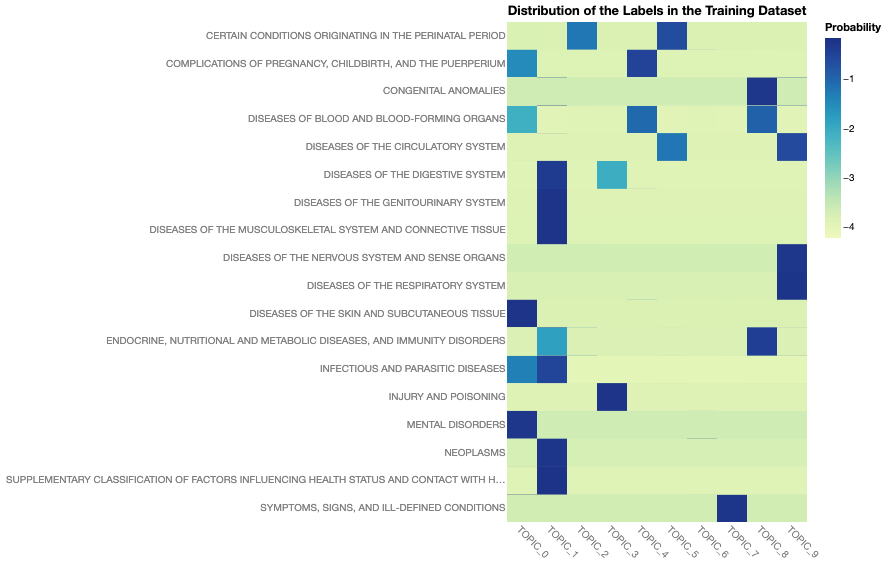

In [21]:
from IPython.display import Image
display(Image(filename=os.path.join(figure_path, 'topic_distribution_heatmap.png')))

In [22]:
# Check the distribution and percentage of the labels in the training dataset
y_train.value_counts(normalize=True)

# Plot the distribution and percentage of true labels
chart(
    df=y_train.value_counts(normalize=True).reset_index(),
    x='index:N',
    y='proportion:Q',
    title='Distribution of the Labels in the Training Dataset',
).mark_bar().configure_axisX(labelAngle=45, labelLimit=300, title=None).configure_axisY(title=None)

alt.Chart(...)

##### 5.2.1.2 - Account for the imbalance in the labels

In [23]:
from imblearn.under_sampling import RandomUnderSampler

In [24]:
# Random Undersampling
def random_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

    return X_train_resampled, y_train_resampled


#X_train, y_train = random_undersampling(X_train, y_train)

##### 5.2.1.3 - Confirm the distribution and percentage of the labels in the training dataset

In [25]:
# Check the distribution and percentage of the labels in the training dataset
y_train.value_counts(normalize=True)

# Plot the distribution and percentage of true labels
chart(
    df=y_train.value_counts(normalize=True).reset_index(),
    x='index:N',
    y='proportion:Q',
    title='Distribution of the Labels in the Training Dataset',
).mark_bar().configure_axisX(labelAngle=45, labelLimit=300, title=None).configure_axisY(title=None)

alt.Chart(...)

#### 5.2.2 - Model training

In [28]:
# Train the model
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

clf_features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[clf_features].isna().sum().where(lambda x: x > 0).dropna()}')
print()

# Define the model
n_neighbors = 5
clf_pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors,
    #pca=True,
    #ovr=True
)

clf_model_name = clf_pipeline.named_steps['classifier'].__class__.__name__
if 'one' in clf_model_name.lower():
    clf_model_name = f'OneVsRest {type(clf_pipeline.esitmator).__name__}'
print(f'Classifier: {clf_model_name}')
print()

# Drop rows with missing values in the quantitative features in both X_train and y_train
#non_missing_mask = X_train[clf_features].notna().all(axis=1)

#print(f'Number of available samples: {non_missing_mask.sum()}')
#X_train = X_train.loc[non_missing_mask]
#y_train = y_train.loc[non_missing_mask]

print(f'Shape of X_train: {X_train[clf_features].shape}')
print(f'Features to be fit: \n{X_train[clf_features].columns}')
print()

clf_pipeline.fit(X_train[clf_features], y_train)

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Classifier: RandomForestClassifier

Shape of X_train: (101107, 45)
Features to be fit: 
Index(['SEX', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD',
       'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS',
       'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'RFV1_MOD1',
       'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'TOPIC_0',
       'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6',
       'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', 'passthrough',
                                                  ['SEX', 'ARTHRTIS', 'ASTHMA',
                                                   'CANCER', 'CEBVD', 'CHF',
                                                   'CRF', 'COPD', 'DEPRN',
                                                   'DIABETES', 'HYPLIPID',
                                                   'HTN', 'IHD', 'OBESITY',
                                                   'OSTPRSIS']),
                                                 ('impute', KNNImputer(),
                                                  ['AGE', 'PASTVIS', 'HTIN',
                                                   'WTLB', 'BMI', 'TEMPF',
                                                   'BPSYS', 'BPDIAS']),
                                                 ('onehot',
                                                  OneHotEncoder...
                                                  ['INJDET', 'MAJOR', 'RFV1',
                                                   'RFV2', 'RFV3', 'RFV1_MOD1',
                                                   'RFV2_MOD1', 'RFV3_MOD1',
                                                   'RFV1_MOD2', 'RFV2_MOD2',
                                                   'RFV3_MOD2']),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-9),
                                                  ['CASTAGE'])])),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', n_estimators=1000,
                                        n_jobs=-1, random_state=42))])

##### 5.2.2.1 - Visualize the feature importances of the top 20 features

In [29]:
importances = clf_pipeline.named_steps['classifier'].feature_importances_
feature_names = clf_pipeline[:-1].get_feature_names_out(clf_features)

indices = np.argsort(importances)[::-1]
feature_names = [feature_names[i] for i in indices]

# Plot the feature importances
top_n = 20

chart(
    df=pd.DataFrame({'Feature': feature_names, 'Importance': importances[indices]}).head(top_n),
    x='Feature:N',
    y='Importance:Q',
    title=f'Top {top_n} Feature Importances',
).mark_bar().configure_axisX(labelAngle=45, labelLimit=300, title=None).configure_axisY(title=None)

alt.Chart(...)

#### 5.2.3 - Load and prepare the test dataset

In [32]:
# Load the test dataset
test_df = pd.read_parquet(os.path.join(input_path, 'test.parquet'))

X_test, y_test = build_features.build_features(test_df, features, rfv_df, icd9cm_df, category=icd9cm_category)

Number of available dependent samples: 34040

X Shape: (34040, 48)
y with CATEGORY_1 Shape: (34040,)


In [33]:
# Combine and preprocess textual features
X_test['TEXT'] = X_test.apply(lambda x: build_features.combine_textual(x, textual_features), axis=1)

# Add in word embeddings using BERT and pre-trained BiomedBERT model 
#X_train = build_features.generate_embeddings(X_train)

# Add in topic feature (topic probabilities) using LDA
X_test, vectorizer, tf, lda, topic_features = build_features.generate_topic_features(
    X_test, n_topics=10, n_top_words=10, transform='log'
)

Topic 0:
mental medications disorders psychological medication symptom kind treatment chronic unspecified

Topic 1:
therapeutic specific diagnostic procedures tests blood procedure chronic preventive screening

Topic 2:
symptom system referable symptoms respiratory digestive new pain sense exclude

Topic 3:
disease diseases system endocrine nutritional circulatory chronic immunity metabolic normal_diastolic_blood_pressure

Topic 4:
visit progress treatment nec nos postoperative preoperative post pre surgery

Topic 5:
counseling medical symptom disorders referable mental psychological respiratory treatment nos

Topic 6:
symptom musculoskeletal ache system soreness referable pain discomfort genitourinary new

Topic 7:
symptom skin hair nails referable eyes ears new lesion normal_temperature

Topic 8:
screening preventive general prenatal baby diagnostic insurance exam examinations care

Topic 9:
injury adverse test injuries results type or and location effect

Topic Features: ['TOPIC_0',

In [34]:
# Drop rows with missing values in the quantitative features in both X_train and y_train
#non_missing_mask = X_test[clf_features].notna().all(axis=1)

#print(f'Number of available samples: {non_missing_mask.sum()}')
#X_test = X_test.loc[non_missing_mask]
#y_test = y_test.loc[non_missing_mask]

In [35]:
# Check the distribution and percentage of true labels
y_test.value_counts(normalize=True)

# Plot the distribution and percentage of true labels
chart(
    df=y_test.value_counts(normalize=True).reset_index(),
    x='index:N',
    y='proportion:Q',
    title='Distribution of True Labels',
).mark_bar().configure_axisX(labelAngle=45)

alt.Chart(...)

#### 5.2.4 - Prediction and Metrics

In [36]:
y_pred = clf_pipeline.predict(X_test)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [37]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_pred_encoded = le.transform(y_pred)

n_classes = len(le.classes_)
y_test_binarized = label_binarize(y_test_encoded, classes=range(n_classes))
y_pred_binarized = label_binarize(y_pred_encoded, classes=range(n_classes))

lrap = label_ranking_average_precision_score(y_test_binarized, y_pred_binarized)
print(f'Label Ranking Average Precision Score: {lrap}')

Label Ranking Average Precision Score: 0.6106247551897896


In [38]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Weighted Prediction F1 Score: {f1}')

print(classification_report(y_test[y_test.notna()], y_pred[y_test.notna()]))

Prediction Accuracy: 0.5877203290246769
Weighted Prediction F1 Score: 0.5632480472659599
                                                                                                    precision    recall  f1-score   support

                                            CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.25      0.11      0.15        64
                                        COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.59      0.10      0.17       809
                                                                              CONGENITAL ANOMALIES       0.44      0.19      0.27       347
                                                        DISEASES OF BLOOD AND BLOOD-FORMING ORGANS       0.74      0.21      0.32       356
                                                                DISEASES OF THE CIRCULATORY SYSTEM       0.52      0.45      0.48      2146
                                                                  DISE

#### 5.2.5 - Confusion matrix

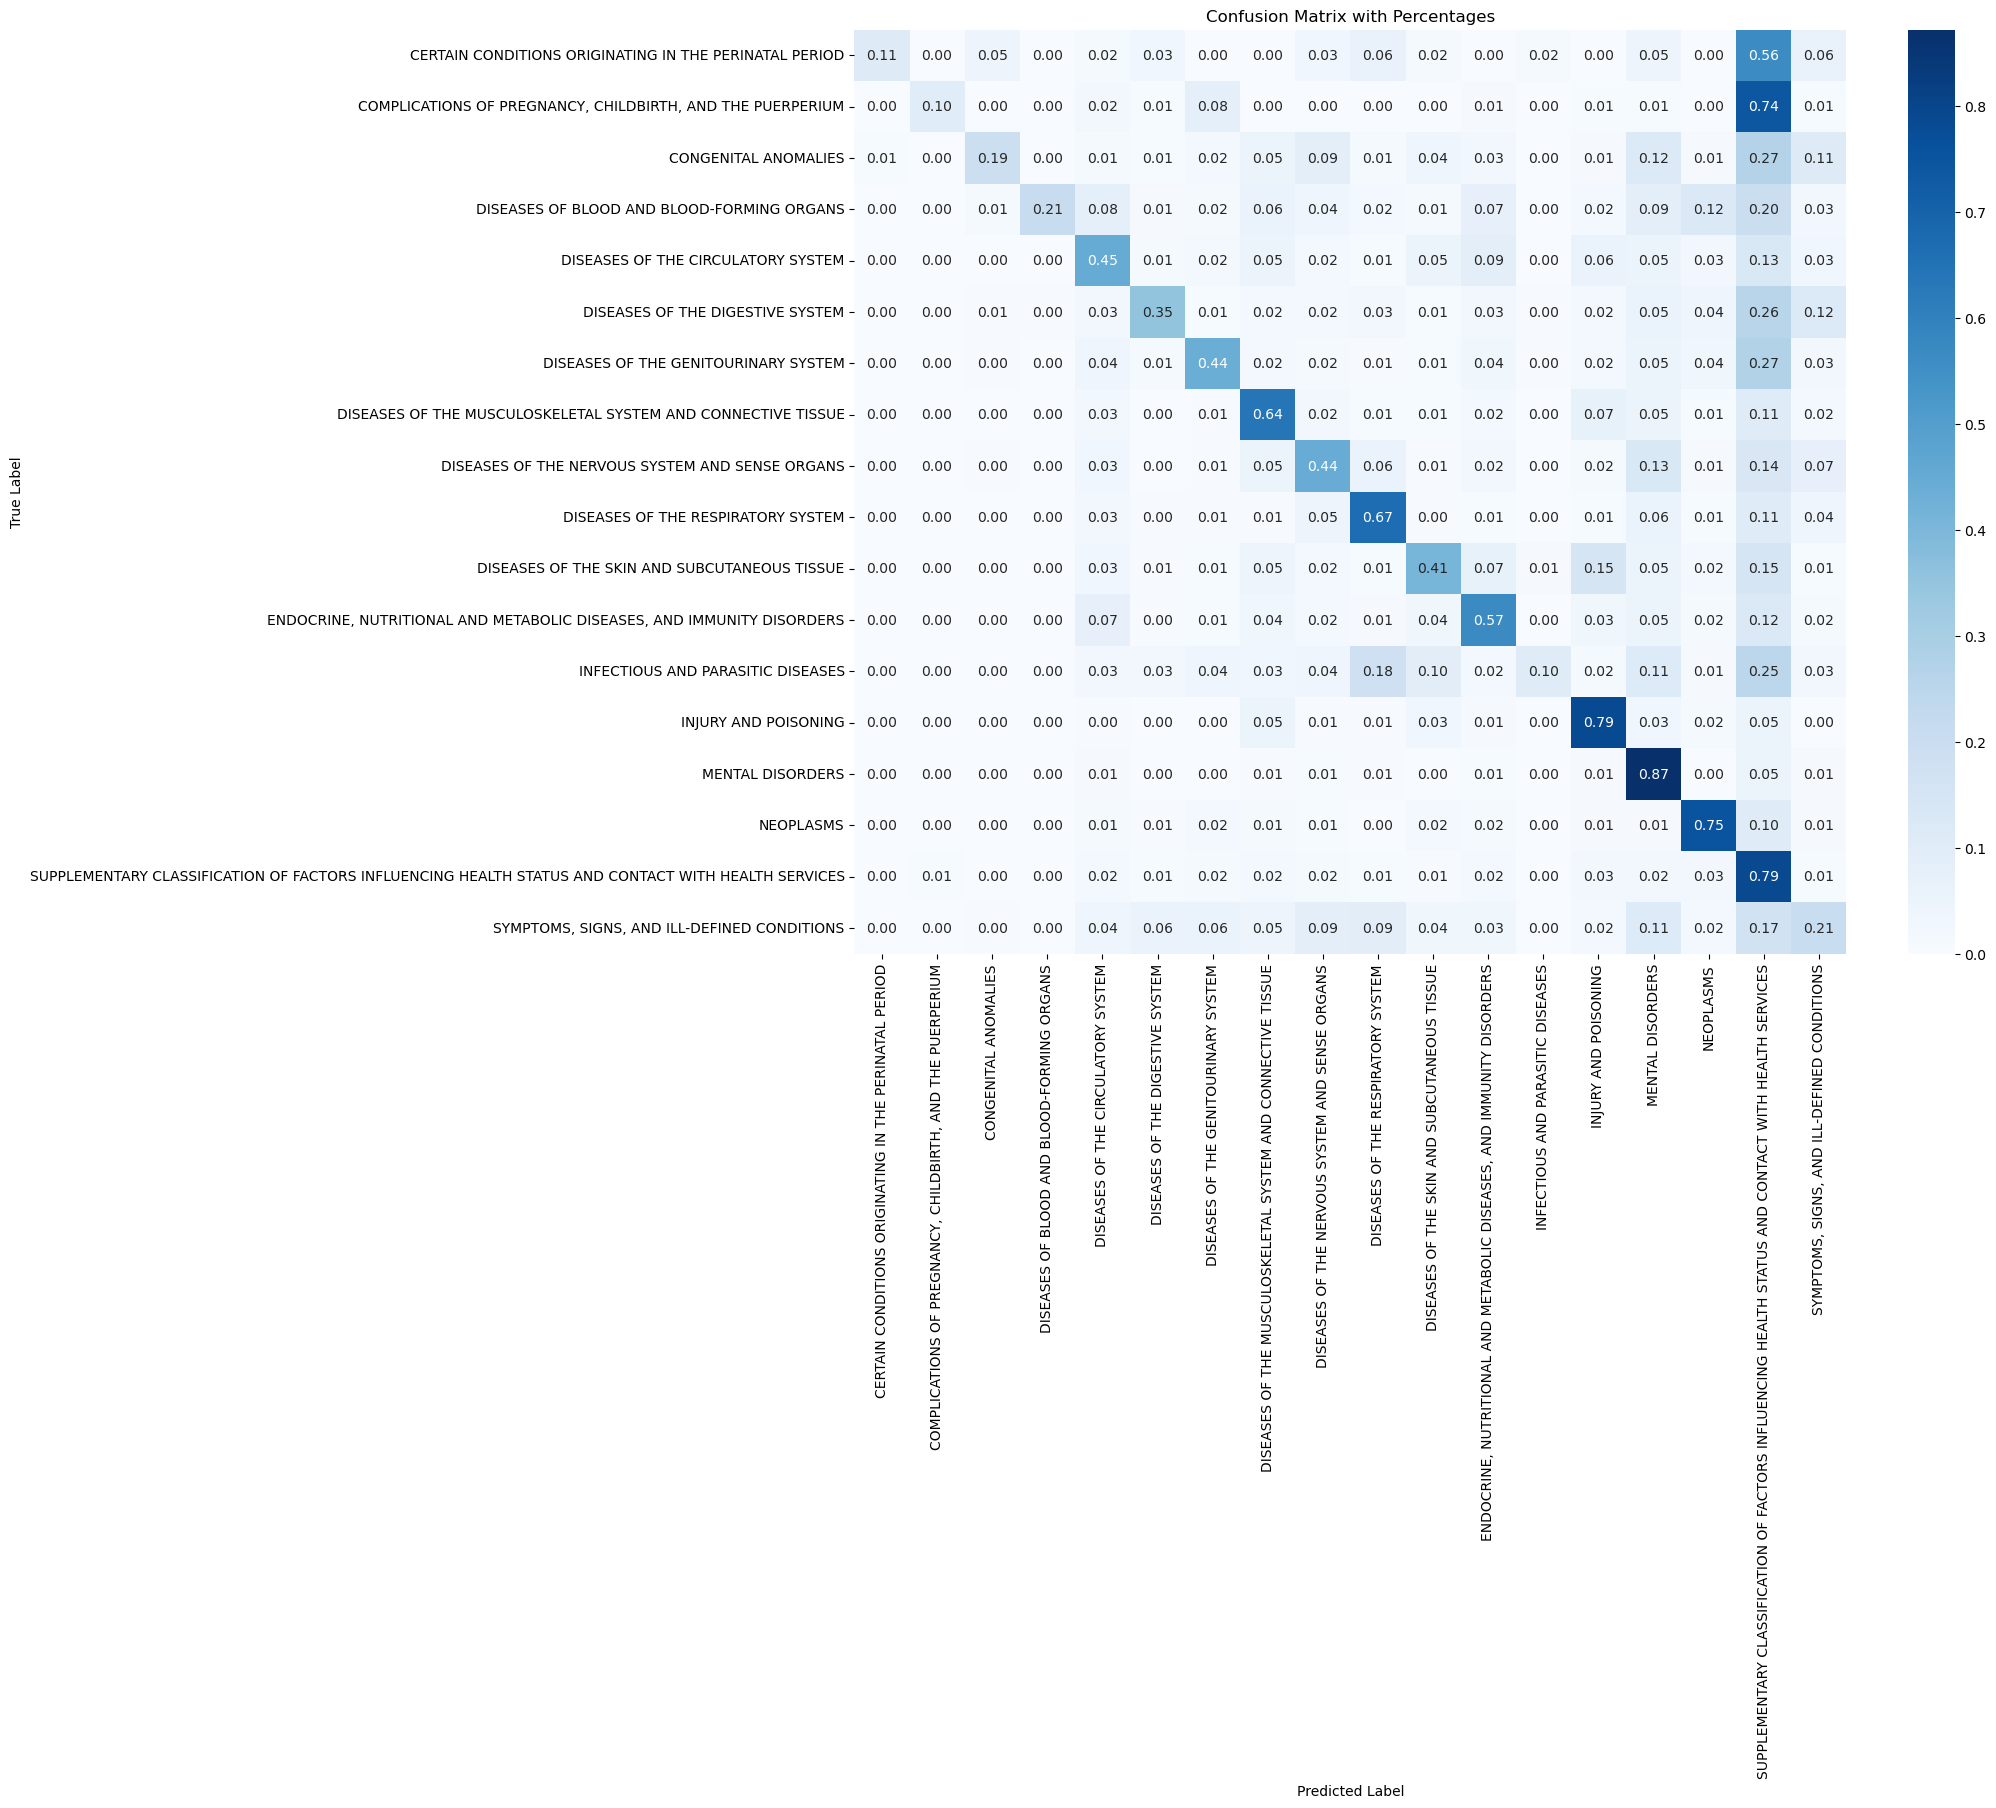

In [39]:
# Plot the confusion matrix with percentages
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 12))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=clf_pipeline.classes_, yticklabels=clf_pipeline.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()

## 6 - Extract text features for each group

In [ ]:
# Load custom function to combine text features
import sys
sys.path.append('../src/features/')

from combine_textual import combine_features

#### 6.1 - Aggregate text data by group

In [ ]:
# Define the list of textual features to combine
textual_features = [
    'AGE', 'SEX', 'USETOBAC', 
    'MAJOR', 'RFV1', 'RFV2', 'RFV3', 
    'BMI', 'TEMPF', 'BPSYS', 'BPDIAS',
    'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'NOCHRON', 'DMP',
    'DIAG1', 'DIAG2', 'DIAG3'
]

# Export the list of textual features
with open(os.path.join(file_path, 'textual_features.json'), 'w') as f:
    json.dump(textual_features, f)

# Combine the text features
train_df['CombinedText'] = train_df.apply(lambda x: combine_features(x, textual_features), axis=1)

train_df.CombinedText.head()

In [ ]:
train_df.CombinedText.notna().sum()

#### 6.2 - Preprocess text data

In [ ]:
import spacy
import re

In [ ]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(row):
    row = re.sub(r'(\d+),(\d+)', r'\1\2', row)
    row = re.sub(r'(\d+)-(\d+)', r'\1_\2', row)
    doc = nlp(row)
    processed_text = ' '.join(token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct)
    row = re.sub(r'(\d+)_(\d+)', r'\1-\2', row)
    return processed_text

In [ ]:
train_df['ProcessedText'] = train_df['CombinedText'].apply(preprocess_text)

In [ ]:
train_df.ProcessedText.head()

In [ ]:
# Save the preprocessed DataFrame
processed_file_path = os.path.join('..', 'data', 'processed')
train_df.to_csv(os.path.join(processed_file_path, f'train_{clustering_model_name}.csv'), index=False)

#### 6.3 - Calculate term frequencies

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Method 1
# Calculate the TF-IDF for each cluster,
# taking the ProcessedText of each cluster as the documents,
# and the ProcessedText of the entire dataset as the corpus

#clustered_text = train_df.groupby('cluster')['ProcessedText'].apply(lambda row: ' '.join(row)).reset_index()

#vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
#tfidf_matrix = vectorizer.fit_transform(clustered_text['ProcessedText'])

#print(tfidf_matrix)

#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#tfidf_df

In [ ]:
# Method 2
# Calculate the TF-IDF of each row within each cluster
# Calculate the average TF-IDF for each cluster

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(train_df['ProcessedText'])

# Calculate the average TF-IDF for each cluster
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
cluster_tfidf = pd.concat([train_df['cluster'], tfidf_df], axis=1).groupby('cluster').mean()

cluster_tfidf

In [ ]:
# Punish the weight of '\d+_year_old' by multiplying it by 0.5, using the regex pattern

#tfidf_df = tfidf_df.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)
#cluster_tfidf = cluster_tfidf.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)

#cluster_tfidf

#### 6.4 - Generate word clouds for each group

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Plot the word cloud for each cluster basd on the average TF-IDF
for i in range(n_clusters):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(cluster_tfidf.loc[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {i}')
    plt.show()

## 7 - Medical pathways

In [ ]:
# 'services' features
binary_services = [feature for feature in variables['services'] if train_df[feature].nunique() <= 2]
print(f'Binary Services: {binary_services}')

nominal_services = [feature for feature in variables['services'] if feature not in binary_services]
print(f'Nominal Services: {nominal_services}')
print()

# 'medicationsAndImmunizations' features
quantitative_med = ['NUMNEW', 'NUMCONT']
print(f'Quantitative Medications: {quantitative_med}')

binary_med = [feature for feature in variables['medicationsAndImmunizations'] if train_df[feature].nunique() <= 2 and feature not in quantitative_med]
print(f'Binary Medications: {binary_med}')

nominal_med = [feature for feature in variables['medicationsAndImmunizations'] if feature not in binary_med and feature not in quantitative_med]
print(f'Nominal Medications: {nominal_med}')
print()

# 'providersSeen' features
binary_ps = [feature for feature in variables['providersSeen'] if train_df[feature].nunique() <= 2]
print(f'Binary Providers Seen: {binary_ps}')
print()

# 'visitDisposition' features
binary_vd = [feature for feature in variables['visitDisposition'] if train_df[feature].nunique() <= 2]
print(f'Binary Visit Disposition: {binary_vd}')
print()

# 'DIAG' features
nominal_diag = ['DIAG1', 'DIAG1_CAT1', 'DIAG1_CAT2']
print(f'Nominal Diagnosis: {nominal_diag}')
text_diag = 'DIAG1_TEXT'
print(f'Text Diagnosis: {text_diag}')